In [1]:
import glob
import os
import sys
import time as time_module


import numpy as np
import pandas as pd
from mvgavg import mvgavg
import skimage
import importlib
import matplotlib.pyplot as plt
%matplotlib widget

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools

PAMFluo_path = "C:/Users/Lab/Desktop/DREAM_repo/Codes_Alienor/PAMFluo-dynamic_python"
if PAMFluo_path not in sys.path:
    sys.path.append(PAMFluo_path)

import VoltageIntensityClass


In [2]:
######## Set the path to experimental and processed data ########

path = "E:/Experimental_data/DREAM_microscope/"
exp = "2023-11-22_14_45_Oscillation_Protocol/"

folder = path + exp
data_processing_folder = folder + "data_processing/"
if not os.path.exists(data_processing_folder):
    os.mkdir(data_processing_folder)


In [3]:
######## Load photodiode outputs ########

list_photodiode_output = glob.glob(folder + "*output*")

outputs_photodiode = []
for i in list_photodiode_output:
    outputs_photodiode.append(pd.read_csv(i))

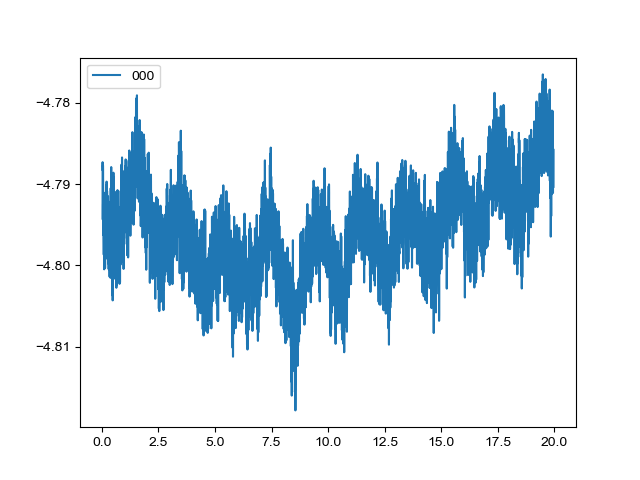

In [4]:
# Plot photodiode outputs

# "time" : time in seconds
# "Intensity" : measured intensity in V
# "Fluo" : intensity measured by the MPPC/only noise if mirror is closed
# "Blue" : set intensity for blue LED in V
# "Purple" : set intensity for purple LED in V
# "Green" : set intensity for green LED in V
# "Trigger" : trigger signal for the camera
# "jspq" : unknown

avg = 50
fig, ax = plt.subplots()
for i, output in enumerate(outputs_photodiode):
    x = mvgavg(output["time"], avg)
    y = mvgavg(output["Intensity"], avg)
    #y2 = mvgavg(output["Blue"], avg)
    ax.plot(x, y, '-', label= list_photodiode_output[i].split("\\")[-1].split("_")[-1].split(".csv")[0], color = f"C{i}")
    #ax.plot(x, y2, color = f"C{i}")

ax.legend()


In [5]:
######## Load videos ########

loading_time = time_module.time()

video_times = []
videos = []

for file in sorted(glob.glob(folder + "*video_timing*"), key=os.path.getmtime):
    video_times.append(np.load(file))

for file in sorted(glob.glob(folder + "*video.tiff"), key=os.path.getmtime):
    videos.append(skimage.io.imread(file))

    

N = len(videos) # number of videos
H = videos[0].shape[1] # height if image in pixels
W = videos[0].shape[2] # width of image in pixels
T = []
for i, video in enumerate(videos):
    T.append(video.shape[0])


loading_time = time_module.time() - loading_time
print("Loading time = " + str(loading_time) + "s")


Loading time = 0.0954132080078125s


In [6]:
######### Create sample video ########
if True:
    sample_video = videos[0]
    skimage.io.imsave(data_processing_folder + "sample_video_marcelo.tiff", sample_video)

sample_video = skimage.io.imread(data_processing_folder + "sample_video_marcelo.tiff")

C:\Users\Lab\AppData\Local\Temp\ipykernel_18572\2886854847.py:4: UserWarning: E:/Experimental_data/DREAM_microscope/2023-11-22_14_45_Oscillation_Protocol/data_processing/sample_video_marcelo.tiff is a low contrast image
  skimage.io.imsave(data_processing_folder + "sample_video_marcelo.tiff", sample_video)


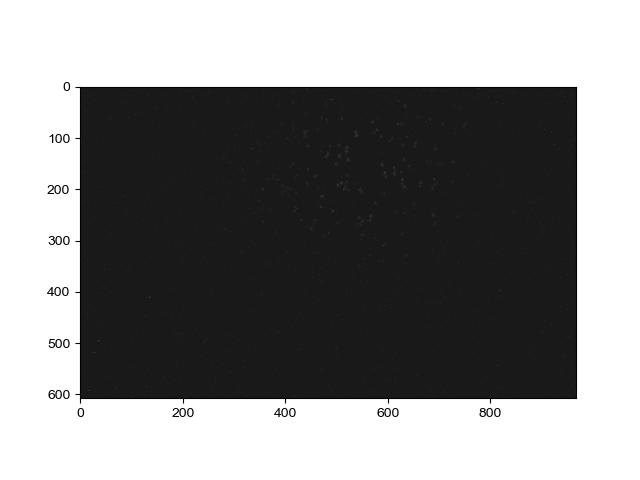

In [7]:
sample_image = sample_video.max(axis=0)
plt.figure(); plt.imshow(sample_image, cmap="gray")

Segmentation time = 4.485128164291382s


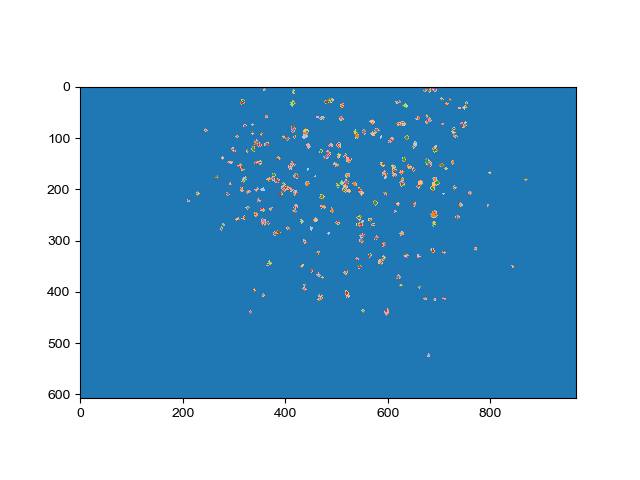

In [8]:
######### Perform segmentation based on sample video ########

if True:
    import seg_func
    importlib.reload(seg_func)

    segmentation_time = time_module.time()
    mask, FO = seg_func.im_seg(sample_video)

    np.save(data_processing_folder + "/mask.npy", mask)

    segmentation_time = time_module.time() - segmentation_time
    print("Segmentation time = " + str(segmentation_time) + "s")

mask = np.load(data_processing_folder + "/mask.npy")
plt.figure(); plt.imshow(mask, cmap='tab20')


In [9]:
n_pixel = []
for i in range(np.max(mask)):
    n_pixel.append(np.count_nonzero(mask == i+1))

In [10]:
np.max(mask)

319

In [11]:
######### Use mask to compute single cell dynamics ########
frame_rate = np.array([5.     , 1.5625 , 0.78125]) # frame rate of the camera in Hz for each video

if True:
    
   
    from tqdm import tqdm

    nb_cell = np.max(mask)

    Cell = np.zeros([nb_cell,N,max(T)])
    Cell_std = np.zeros([nb_cell,N,max(T)])

    for k in tqdm(range(nb_cell)):
        Intensity = np.zeros([N,max(T)])
        Intensity_std = np.zeros([N,max(T)])
        for i in range(N):
            fluo = np.zeros(max(T))
            fluo_std =  np.zeros(max(T))
            for j in range(T[i]):        
                fluo[j] = np.mean(videos[i][j][mask == k])
                fluo_std[j] = np.std(videos[i][j][mask == k])
            Intensity[i][:T[i]] = fluo[:T[i]]
            Intensity_std[i][:T[i]] = fluo_std[:T[i]]
        Cell[k][:N,:max(T)] = Intensity
        Cell_std[k][:N,:max(T)] = Intensity_std
    
    np.save(data_processing_folder + "/Single_cell_dynamics.npy", Cell)
    np.save(data_processing_folder + "/Single_cell_dynamics_std.npy", Cell_std)

Cell = np.load(data_processing_folder + "/Single_cell_dynamics.npy")
Cell_std = np.load(data_processing_folder + "/Single_cell_dynamics_std.npy")


100%|██████████| 319/319 [00:05<00:00, 59.26it/s]


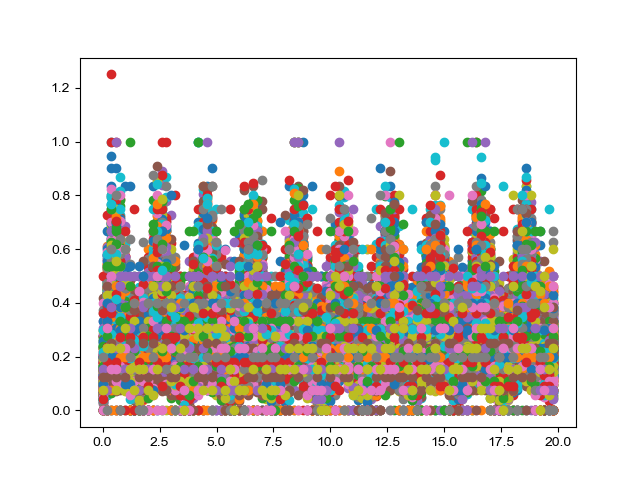

In [12]:
######### Plot single cell dynamics ########

nb_cell = len(Cell)
nb_video = len(Cell[0])
frames = len(Cell[0][0])

avg = 1

for i in range(nb_video):
    fig, ax = plt.subplots()
    for j in range(nb_cell):
        x = mvgavg(video_times[i] - video_times[i][0], avg)
        y = mvgavg(Cell[j][i][0:len(x)], avg)
        ax.plot(x,y,'o', label = "Cell " + str(j+1))

In [82]:
freq = [0.5, 1/16, 1/64]
acq_time = 3600
nb_period = (np.array(freq)*acq_time).astype(int)
nb_period

array([1800,  225,   56])

In [13]:
sum_cell = np.zeros_like(Cell[0])
for i in range(len(Cell)):
    sum_cell += Cell[i]


In [16]:
    offsets = np.array([0, 6.63106037, 10.63690732, 13.84158488, 21.85327878,
       29.06380328, 49.09303803, 70.72461155, 83.54332179, 97.16320142]
                       + [0, 6.63106037, 10.63690732, 13.84158488, 21.85327878,
       29.06380328, 49.09303803, 70.72461155, 83.54332179][::-1])/100

In [17]:
offsets

array([0.        , 0.0663106 , 0.10636907, 0.13841585, 0.21853279,
       0.29063803, 0.49093038, 0.70724612, 0.83543322, 0.97163201,
       0.83543322, 0.70724612, 0.49093038, 0.29063803, 0.21853279,
       0.13841585, 0.10636907, 0.0663106 , 0.        ])

In [14]:
data_dict = {}
time_dict = {}
for i in range(len(sum_cell)):
    time_dict[i] = video_times[i] - video_times[i][0]
    data_dict[i] = sum_cell[i]


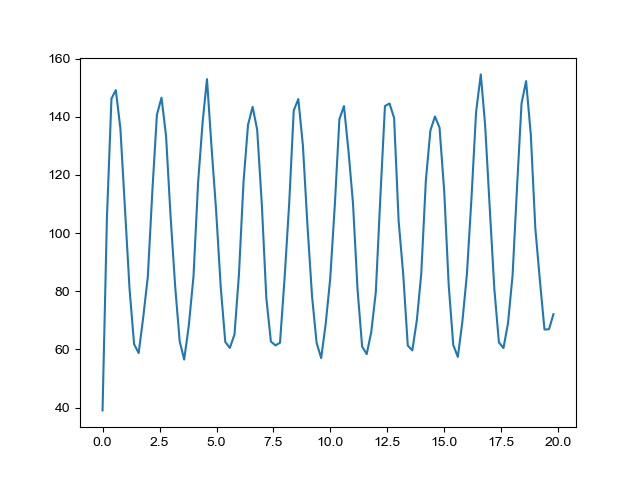

In [15]:
for i in range(len(time_dict)):
    fig, ax = plt.subplots()
    ax.plot(time_dict[i], data_dict[i][:len(time_dict[i])])

In [17]:
importlib.reload(VoltageIntensityClass)

a480 = 82
a532=7.7

V = VoltageIntensityClass.VoltageIntensity(folder = "E:/Experimental_data/DREAM_microscope/2023-10-18_16_53_bode_diagram")
I = V.get_intensity_voltage("blue", 1, np.array(Actinic_measured_volt))*1e6*a480/a532
I_sat = V.get_intensity_voltage("blue", 1, np.array(Sat_measured_volt))*1e6*a480/a532

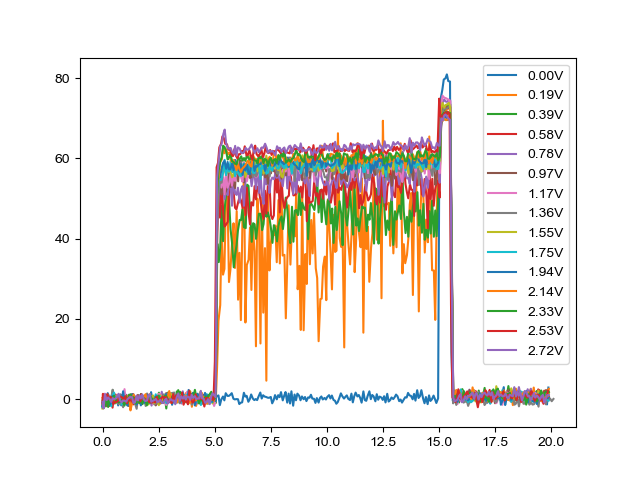

In [27]:
fig, ax =  plt.subplots()
data_PAM_like = {}

for i, k in enumerate(data_df.columns):
    x = time_df[k].copy()
    I_stat_index = [tools.closest_index(x, 5.1), tools.closest_index(x, 15.1)]
    I_sat_index = [tools.closest_index(x, 15.1), tools.closest_index(x, 15.64)]
    y = data_df[k].copy()
    y[I_sat_index[0]:I_sat_index[1]] = y[I_sat_index[0]:I_sat_index[1]]/Sat_measured_volt[i]
    if i > 0:
        y[I_stat_index[0]:I_stat_index[1]] = y[I_stat_index[0]:I_stat_index[1]]/Actinic_measured_volt[i]
    data_PAM_like[k] = y
    ax.plot(x,y, '-', label = k)
ax.legend()

fig.savefig(data_processing_folder + "PAM_like.png", dpi=300)

data_PAM_like_df = pd.DataFrame(data_PAM_like)




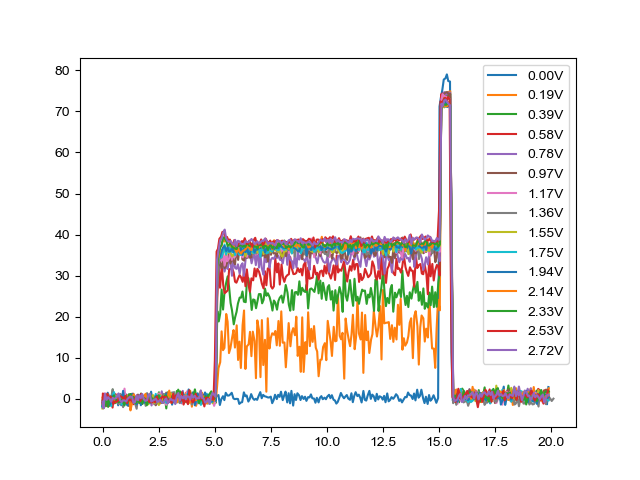

In [19]:
fig, ax =  plt.subplots()
data_PAM_like = {}

for i, k in enumerate(data_df.columns):
    x = time_df[k].copy()
    I_stat_index = [tools.closest_index(x, 5.1), tools.closest_index(x, 15.1)]
    I_sat_index = [tools.closest_index(x, 15.1), tools.closest_index(x, 15.64)]
    y = data_df[k].copy()
    y[I_sat_index[0]:I_sat_index[1]] = y[I_sat_index[0]:I_sat_index[1]]/Sat_set_volt
    if i > 0:
        y[I_stat_index[0]:I_stat_index[1]] = y[I_stat_index[0]:I_stat_index[1]]/Actinic_set_volt[i]
    data_PAM_like[k] = y
    ax.plot(x,y, '-', label = k)
ax.legend()

fig.savefig(data_processing_folder + "PAM_like_set_volt.png", dpi=300)

data_PAM_like_df = pd.DataFrame(data_PAM_like)




C:\Users\Lab\AppData\Local\Temp\ipykernel_1460\154829643.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Text(0, 0.5, 'Actinic voltage measured (V)')

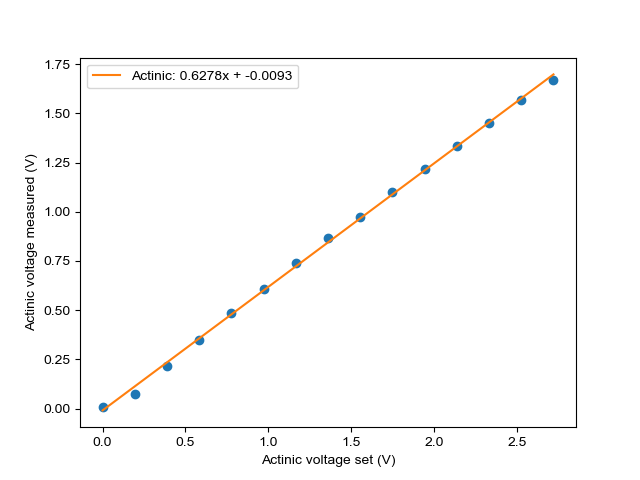

In [20]:
fig, ax = plt.subplots()
popt, xfit, yfit = tools.lin_fit(Actinic_set_volt, Actinic_measured_volt, Actinic_set_volt[0], Actinic_set_volt[-1], 100)
ax.plot(Actinic_set_volt, Actinic_measured_volt, 'o')
ax.plot(xfit, yfit, label = f"Actinic: {popt[0]:.4f}x + {popt[1]:.4f}")
ax.legend()
ax.set_xlabel("Actinic voltage set (V)")
ax.set_ylabel("Actinic voltage measured (V)")

In [21]:
def compute_params(Data_df,Time_df):

    F_max = []
    F_stat = []
    phi_stat = []
    NPQ = []
    ETR = []

    for i, k in enumerate(Data_df.columns):
        F_max.append(np.max(Data_df[k][tools.closest_index(Time_df[k],15.2):tools.closest_index(Time_df[k],15.6)]))
        NPQ.append((F_max[0] - F_max[i])/F_max[i])
        if i == 0:
            F_stat.append(0)
            phi_stat.append(0)
            ETR.append(0)
            continue
        F_stat.append(np.mean(Data_df[k][tools.closest_index(Time_df[k], 10):tools.closest_index(Time_df[k], 14.9)]))
        phi_stat.append((F_max[i] - F_stat[i]) / F_max[i])
        ETR.append(phi_stat[i] * Actinic_measured_volt[i])
       
    norm = F_max[0]
    
    F_max = list(np.array(F_max)/norm)
    F_stat = list(np.array(F_stat)/norm)
        
    params_df = pd.DataFrame({'Actinic_set': Actinic_set_volt ,'Actinic_arduino': Actinic_measured_volt, 'Sat_pulse_arduino': Sat_measured_volt, 'F_max': F_max, 'F_stat': F_stat, 'phi_stat': phi_stat, 'NPQ': NPQ, 'ETR': ETR})
    
    return params_df

In [28]:
params_df = compute_params(data_PAM_like_df, time_df)
params_df.to_csv(data_processing_folder + "params.csv")

params_df

,Actinic_set,Actinic_arduino,Sat_pulse_arduino,F_max,F_stat,phi_stat,NPQ,ETR
0,0.000000,0.010069,3.319185,1.000000,0.000000,0.000000,0.000000,0.000000
1,0.194286,0.074279,3.484357,0.903073,0.525922,0.417631,0.107330,0.031021
2,0.388571,0.214653,3.434113,0.908092,0.567160,0.375438,0.101210,0.080589
3,0.582857,0.348732,3.476270,0.899252,0.647003,0.280510,0.112035,0.097823
4,0.777143,0.483299,3.401589,0.922534,0.681442,0.261337,0.083971,0.126304
5,0.971429,0.605491,3.546868,0.884878,0.710948,0.196558,0.130100,0.119014
6,1.165714,0.741717,3.335899,0.934389,0.716965,0.232691,0.070218,0.172591
7,1.360000,0.867460,3.413854,0.900139,0.714926,0.205760,0.110940,0.178489
8,1.554286,0.974736,3.323090,0.912605,0.727207,0.203153,0.095764,0.198020
9,1.748571,1.101990,3.473817,0.868908,0.724158,0.166589,0.150869,0.183579


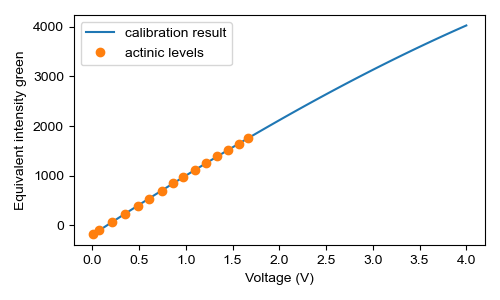

In [23]:
V = VoltageIntensityClass.VoltageIntensity(folder = "E:/Experimental_data/DREAM_microscope/2023-10-18_16_53_bode_diagram")

a480 = 82
a532=7.7

voltage_fit = np.linspace(0, 4, 100)
intensity_fit = V.get_intensity_voltage("blue", 1, voltage_fit)*1e6
intensity_green_fit = intensity_fit*a480/a532
intensity_green = V.get_intensity_voltage("blue", 1, Actinic_measured_volt)*1e6*a480/a532


fig, ax = plt.subplots(figsize = (5,3))
ax.plot(voltage_fit, intensity_green_fit, label = "calibration result")
ax.plot(Actinic_measured_volt, intensity_green, 'o', label = "actinic levels")
ax.legend()

ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Equivalent intensity green")

fig.tight_layout()



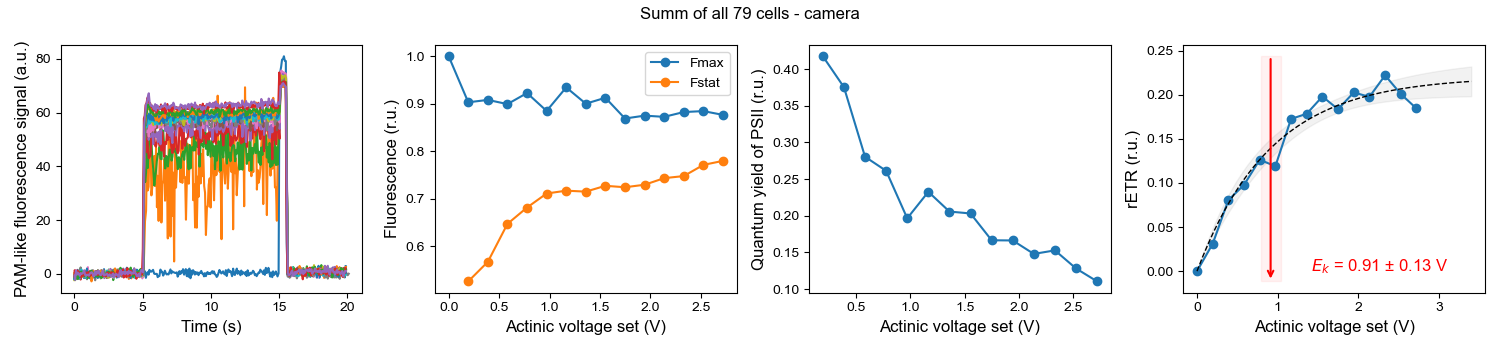

In [29]:
import math_functions as mf

font_size = 12

fig, ax = plt.subplots(1,4, figsize = (15,3.5))
fig.suptitle(f"Summ of all {nb_cell} cells - camera")

for i in data_PAM_like_df.columns:
    x = time_df[i] - time_df[i][0]
    y = data_PAM_like_df[i]
    ax[0].plot(x,y, '-', label = i)
    ax[0].set_xlabel("Time (s)", fontsize = font_size)
    ax[0].set_ylabel("PAM-like fluorescence signal (a.u.)", fontsize = font_size)

ax[1].plot(Actinic_set_volt, params_df.F_max, 'o-', label = "Fmax")
ax[1].plot(Actinic_set_volt[1:], params_df.F_stat[1:], 'o-', label = "Fstat")
ax[1].set_xlabel("Actinic voltage set (V)", fontsize = font_size)
ax[1].set_ylabel("Fluorescence (r.u.)", fontsize = font_size)
ax[1].legend()
ax[2].plot(Actinic_set_volt[1:], params_df.phi_stat[1:], 'o-', label = "phi_stat")
ax[2].set_xlabel("Actinic voltage set (V)", fontsize = font_size)
ax[2].set_ylabel("Quantum yield of PSII (r.u.)", fontsize = font_size)
ax[3].plot(Actinic_set_volt, params_df.ETR, 'o-', label = "ETR")
ax[3].set_xlabel("Actinic voltage set (V)", fontsize = font_size)
ax[3].set_ylabel("rETR (r.u.)", fontsize = font_size)

popt, pcov, xfit, yfit = tools.Ek_fit(Actinic_set_volt, params_df.ETR, 0, 3.4, 50, p0 = [1, 1])

err = tools.my_err(xfit, popt, pcov, mf.Ek)
ax[3].fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = 'k')

ax[3].plot(xfit, yfit, '--', color ='k', linewidth = 1)
Ek = popt[1]
Ek_err = np.sqrt(np.diag(pcov))[1]
ax[3].annotate("", xy=(Ek, ax[3].get_ylim()[0]), xytext=(Ek, ax[3].get_ylim()[1]), arrowprops=dict(arrowstyle="->", color="red", linewidth = 1.5))
ax[3].fill_betweenx(ax[3].get_ylim(), Ek - Ek_err, Ek + Ek_err, color='red', alpha=0.05)
ax[3].text(Ek + 0.5, 0, f"$E_k$ = {Ek:.2f} ± {Ek_err:.2f} V", fontsize = 12, color = "red")


fig.tight_layout()
fig.savefig(data_processing_folder + "PAM_like_dream.png", dpi=300)

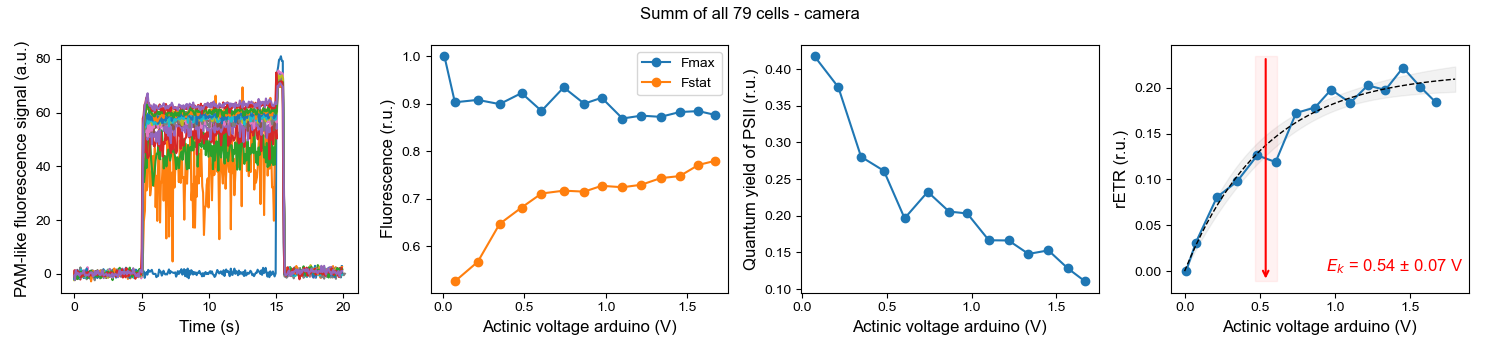

In [30]:
import math_functions as mf

font_size = 12

fig, ax = plt.subplots(1,4, figsize = (15,3.5))
fig.suptitle(f"Summ of all {nb_cell} cells - camera")

for i in data_PAM_like_df.columns:
    x = time_df[i] - time_df[i][0]
    y = data_PAM_like_df[i]
    ax[0].plot(x,y, '-', label = i)
    ax[0].set_xlabel("Time (s)", fontsize = font_size)
    ax[0].set_ylabel("PAM-like fluorescence signal (a.u.)", fontsize = font_size)

ax[1].plot(Actinic_measured_volt, params_df.F_max, 'o-', label = "Fmax")
ax[1].plot(Actinic_measured_volt[1:], params_df.F_stat[1:], 'o-', label = "Fstat")
ax[1].set_xlabel("Actinic voltage arduino (V)", fontsize = font_size)
ax[1].set_ylabel("Fluorescence (r.u.)", fontsize = font_size)
ax[1].legend()
ax[2].plot(Actinic_measured_volt[1:], params_df.phi_stat[1:], 'o-', label = "phi_stat")
ax[2].set_xlabel("Actinic voltage arduino (V)", fontsize = font_size)
ax[2].set_ylabel("Quantum yield of PSII (r.u.)", fontsize = font_size)
ax[3].plot(Actinic_measured_volt, params_df.ETR, 'o-', label = "ETR")
ax[3].set_xlabel("Actinic voltage arduino (V)", fontsize = font_size)
ax[3].set_ylabel("rETR (r.u.)", fontsize = font_size)

popt, pcov, xfit, yfit = tools.Ek_fit(Actinic_measured_volt, params_df.ETR, 0, 1.8, 50, p0 = [1, 1])

err = tools.my_err(xfit, popt, pcov, mf.Ek)
ax[3].fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = 'k')

ax[3].plot(xfit, yfit, '--', color ='k', linewidth = 1)
Ek = popt[1]
Ek_err = np.sqrt(np.diag(pcov))[1]
ax[3].annotate("", xy=(Ek, ax[3].get_ylim()[0]), xytext=(Ek, ax[3].get_ylim()[1]), arrowprops=dict(arrowstyle="->", color="red", linewidth = 1.5))
ax[3].fill_betweenx(ax[3].get_ylim(), Ek - Ek_err, Ek + Ek_err, color='red', alpha=0.05)
ax[3].text(Ek + 0.4, 0, f"$E_k$ = {Ek:.2f} ± {Ek_err:.2f} V", fontsize = 12, color = "red")


fig.tight_layout()
fig.savefig(data_processing_folder + "PAM_like_dream.png", dpi=300)

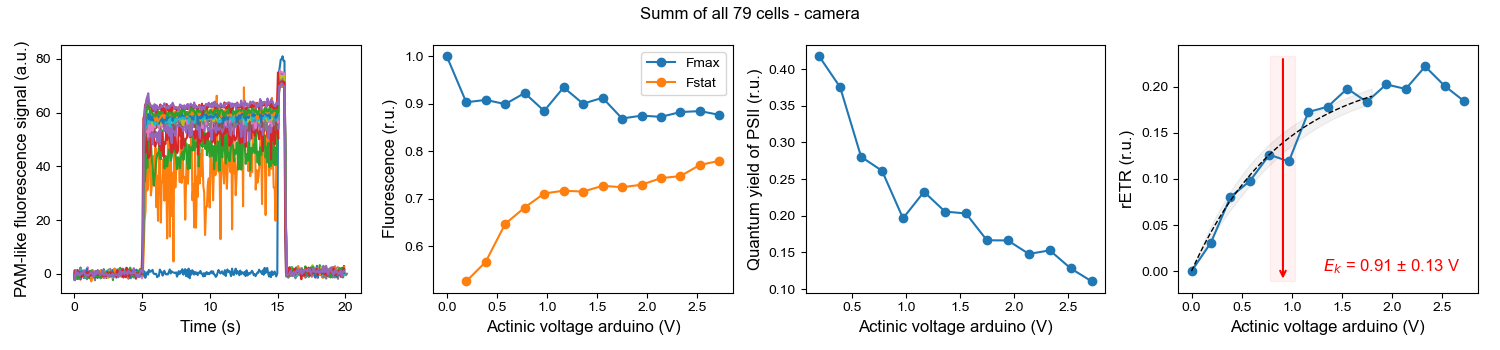

In [31]:
import math_functions as mf

font_size = 12

fig, ax = plt.subplots(1,4, figsize = (15,3.5))
fig.suptitle(f"Summ of all {nb_cell} cells - camera")

for i in data_PAM_like_df.columns:
    x = time_df[i] - time_df[i][0]
    y = data_PAM_like_df[i]
    ax[0].plot(x,y, '-', label = i)
    ax[0].set_xlabel("Time (s)", fontsize = font_size)
    ax[0].set_ylabel("PAM-like fluorescence signal (a.u.)", fontsize = font_size)

ax[1].plot(Actinic_set_volt, params_df.F_max, 'o-', label = "Fmax")
ax[1].plot(Actinic_set_volt[1:], params_df.F_stat[1:], 'o-', label = "Fstat")
ax[1].set_xlabel("Actinic voltage arduino (V)", fontsize = font_size)
ax[1].set_ylabel("Fluorescence (r.u.)", fontsize = font_size)
ax[1].legend()
ax[2].plot(Actinic_set_volt[1:], params_df.phi_stat[1:], 'o-', label = "phi_stat")
ax[2].set_xlabel("Actinic voltage arduino (V)", fontsize = font_size)
ax[2].set_ylabel("Quantum yield of PSII (r.u.)", fontsize = font_size)
ax[3].plot(Actinic_set_volt, params_df.ETR, 'o-', label = "ETR")
ax[3].set_xlabel("Actinic voltage arduino (V)", fontsize = font_size)
ax[3].set_ylabel("rETR (r.u.)", fontsize = font_size)

popt, pcov, xfit, yfit = tools.Ek_fit(Actinic_set_volt, params_df.ETR, 0, 1.8, 50, p0 = [1, 1])

err = tools.my_err(xfit, popt, pcov, mf.Ek)
ax[3].fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = 'k')

ax[3].plot(xfit, yfit, '--', color ='k', linewidth = 1)
Ek = popt[1]
Ek_err = np.sqrt(np.diag(pcov))[1]
ax[3].annotate("", xy=(Ek, ax[3].get_ylim()[0]), xytext=(Ek, ax[3].get_ylim()[1]), arrowprops=dict(arrowstyle="->", color="red", linewidth = 1.5))
ax[3].fill_betweenx(ax[3].get_ylim(), Ek - Ek_err, Ek + Ek_err, color='red', alpha=0.05)
ax[3].text(Ek + 0.4, 0, f"$E_k$ = {Ek:.2f} ± {Ek_err:.2f} V", fontsize = 12, color = "red")


fig.tight_layout()
fig.savefig(data_processing_folder + "PAM_like_dream.png", dpi=300)